# Image Colorization using pix2pix
## Bringing Life to Black-and-White Images

Welcome to Image Colorization using pix2pix, an AI-based project designed to transform black-and-white images into colored versions using the pix2pix model. This initiative serves as a practical example of image-to-image translation, leveraging Generative Adversarial Networks (GANs) to explore colorization techniques. While not a cutting-edge or large-scale endeavor, it provides valuable insights and hands-on experience for those interested in understanding and applying the pix2pix model.

## Our Vision

Our goal is to create a straightforward solution for colorizing black-and-white images, focusing on practical application and technical understanding rather than perfection. We aim to demonstrate how the pix2pix model can be used effectively, delivering meaningful results that are useful for experimentation and analysis, while offering a clear window into the workings of GAN-based image processing.

## Technology at the Core

At the heart of this project is the pix2pix model, a generative adversarial network (GAN) renowned for its image-to-image translation capabilities. We’ve adapted this model to focus on colorizing images, training it on the Landscape-Image-Colorization dataset from Kaggle. The standard input size for pix2pix is typically 256x256 pixels. To align with this standard, we upscale the original dataset images, which are 150x150 pixels, to 256x256 pixels for training.

## Training and Fine-Tuning

- **Training on the Dataset**: We train our model on all files from the Landscape-Image-Colorization dataset available on Kaggle. Originally, the dataset images are sized at 150x150 pixels. To optimize performance and match the standard input size for pix2pix, we upscale these images to 256x256 pixels. This adjustment ensures compatibility with the fully convolutional nature of the pix2pix model, which can handle various input sizes but performs best at its standard resolution.

- **Limitations and Results**: While the pix2pix model is fully convolutional and can technically accept larger or smaller images, the colorization outcomes are optimized for the 256x256 resolution used in training. The results provide a solid foundation for image colorization, offering reasonable quality for experimental and analytical purposes, though they may not match professional standards.

## Features

- **Practical Application**: This project is ideal for those looking to explore and apply the pix2pix model, offering a simple implementation to study and experiment with image colorization.

- **Functional Results**: The colorization results are practical but not highly realistic, providing a clear example of how GANs operate rather than aiming for top-tier image quality.

- **Accessible Design**: Easy to use and understand, our approach is built for researchers, developers, and enthusiasts who want to delve into GANs and image processing without needing advanced technical expertise.

## Basic Libraries

In [ ]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras import layers, Model
from visualkeras import layered_view

## Data Preparation Pipeline

This section details the crucial step of preparing the image data for training the image colorization model using pix2pix. Efficient data loading, preprocessing, and splitting are essential for successful model training and evaluation. We use TensorFlow's tf.data API for optimized performance, as implemented in the project.

- **Dataset**: All images from the Landscape-Image-Colorization dataset on Kaggle are used for training. The dataset is stored in two directories: `color` (for colored images) and `gray` (for black-and-white versions), located at `/kaggle/input/landscape-image-colorization/landscape Images/color` and `/kaggle/input/landscape-image-colorization/landscape Images/gray`, respectively. Originally, each image in the dataset is 150x150 pixels, but to align with the standard input size for pix2pix (256x256), these images are upscaled to 256x256 pixels during preprocessing using interpolation.

- **Data Loading**: Images are loaded using the tf.data API to ensure high-performance data pipelines. The API lists and sorts JPG files from both directories, ensuring a one-to-one correspondence between colored and grayscale images. The `load_landscape_dataset` function creates a dataset by pairing corresponding color and grayscale files, leveraging `tf.data.Dataset.zip` for efficient loading.

- **Preprocessing**: Black-and-white (grayscale) images are read as single-channel inputs, and colored versions are read as three-channel outputs. Both types of images are resized to 256x256 pixels and normalized to the range [0, 1] by dividing by 255.0. This preprocessing step ensures consistency and prepares the data for the pix2pix model to learn the mapping from grayscale to colored outputs.

- **Splitting**: The dataset is split into training, validation, and test sets. By default, 5,600 images are used for training (`train_size=5600`), with the remaining images split evenly between validation and test sets. The dataset is shuffled to reduce ordering bias, and the splits are created using `take` and `skip` operations. All datasets (train, validation, and test) are batched with a batch size of 64 and prefetched using `tf.data.AUTOTUNE` for optimal performance during training.

- **Batch Size Explanation**: A batch size of 64 is chosen as a balance between memory usage and training efficiency. This size allows the model to process multiple images simultaneously, which speeds up training by leveraging parallel processing on GPUs or TPUs while keeping memory consumption manageable. A batch size of 64 is large enough to provide stable gradient updates for the pix2pix model but small enough to avoid overwhelming system resources, making it suitable for experimentation with the Landscape-Image-Colorization dataset.

This pipeline ensures that the image colorization model using pix2pix is trained efficiently and effectively, prioritizing simplicity and practicality, even if the results are not highly refined.

In [ ]:
def load_landscape_dataset(color_dir, gray_dir, batch_size=64, train_size=5600):
    # List and sort JPG files
    color_files = sorted([os.path.join(color_dir, f) for f in os.listdir(color_dir) if f.endswith('.jpg')])
    gray_files = sorted([os.path.join(gray_dir, f) for f in os.listdir(gray_dir) if f.endswith('.jpg')])

    assert len(color_files) == len(gray_files), "Mismatched files"
    total = len(color_files)

    # Load and preprocess images
    def load_pair(color_path, gray_path):
        gray = tf.io.read_file(gray_path)
        gray = tf.image.decode_jpeg(gray, channels=1)  # Single channel for gray
        gray = tf.image.resize(gray, [256, 256]) / 255.0

        color = tf.io.read_file(color_path)
        color = tf.image.decode_jpeg(color, channels=3)  # 3 channels for color
        color = tf.image.resize(color, [256, 256]) / 255.0

        return gray, color

    # Create and process dataset
    dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(color_files),
                                  tf.data.Dataset.from_tensor_slices(gray_files)))
    dataset = dataset.map(load_pair, num_parallel_calls=tf.data.AUTOTUNE).shuffle(total)

    # Split datasets
    train_ds = dataset.take(train_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    remaining_ds = dataset.skip(train_size)
    val_size = (total - train_size) // 2
    val_ds = remaining_ds.take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = remaining_ds.skip(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [ ]:
color_dir = "/kaggle/input/landscape-image-colorization/landscape Images/color"
gray_dir = "/kaggle/input/landscape-image-colorization/landscape Images/gray"
train_ds, val_ds, test_ds = load_landscape_dataset(color_dir, gray_dir, batch_size=64)

## Why We Normalize Images

In AI tasks like image processing, we normalize both input (e.g., grayscale) and output (e.g., colorized) images by scaling pixel values to a standard range, such as [0, 1]. This is done by dividing pixel values (typically 0–255 for JPGs) by 255.0. Here’s why:

- **Consistency**: Ensures inputs and outputs are on the same scale, making it easier for models to learn relationships.
- **Stability**: Prevents large pixel values from dominating training, reducing instability.
- **Feature Extraction**: Helps models identify patterns (e.g., brightness, texture) without being distracted by raw intensity variations.

## How Normalization Helps AI Models

Normalization benefits AI models in several ways:

- **Faster Convergence**: Scaled data reduces gradient scales during training, speeding up learning.
- **Gradient Stability**: Prevents vanishing or exploding gradients, ensuring stable weight updates.
- **Better Generalization**: Standardizes data, improving performance on unseen images.
- **Loss Function Efficiency**: Makes loss calculations (e.g., L1, adversarial) more effective by aligning scales.
- **Activation Compatibility**: Ensures compatibility with neural network activation functions, avoiding saturation issues.


Normalizing images is a simple yet crucial step in AI that enhances model performance, stability, and efficiency. It’s especially important for tasks like image colorization, where consistent scaling of inputs and outputs ensures reliable results and faster training.

In [ ]:
def plot_image_pairs(dataset, num_pairs=5):
    # Unbatch the dataset to get individual image pairs
    unbatched_ds = dataset.unbatch()

    # Take the specified number of pairs
    data_iterator = unbatched_ds.take(num_pairs).as_numpy_iterator()

    plt.figure(figsize=(15, 5 * (num_pairs // 5 + 1)))  # Adjust figure size

    for i, (gray, color) in enumerate(data_iterator):
        plt.subplot(num_pairs // 5 + 1, 5, i + 1)
        plt.imshow(gray.squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
        plt.title(f'Grayscale Input {i+1}')
        plt.axis('off')

        plt.subplot(num_pairs // 5 + 1, 5, i + 1 + num_pairs)
        plt.imshow(color)
        plt.title(f'Color Output {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Training Set Samples:


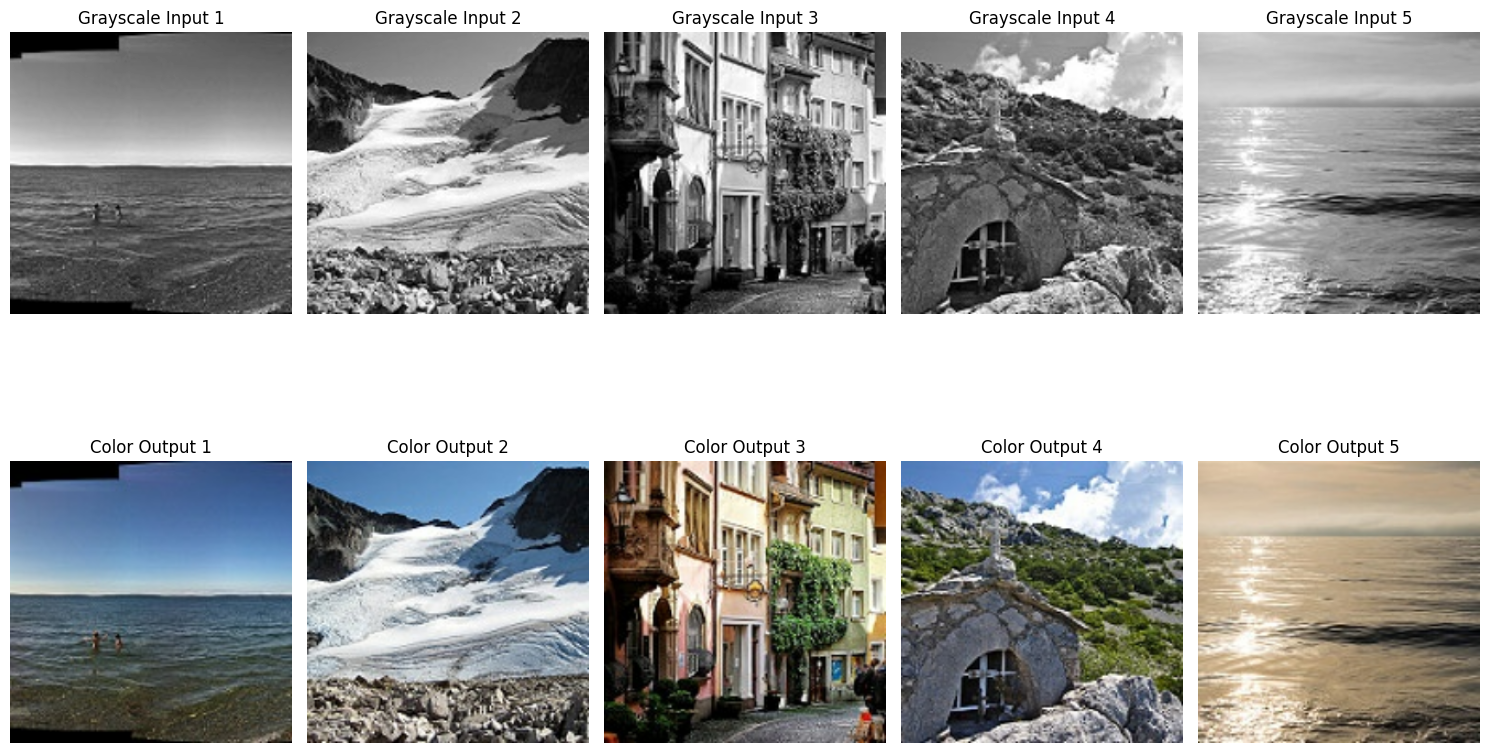

Validation Set Samples:


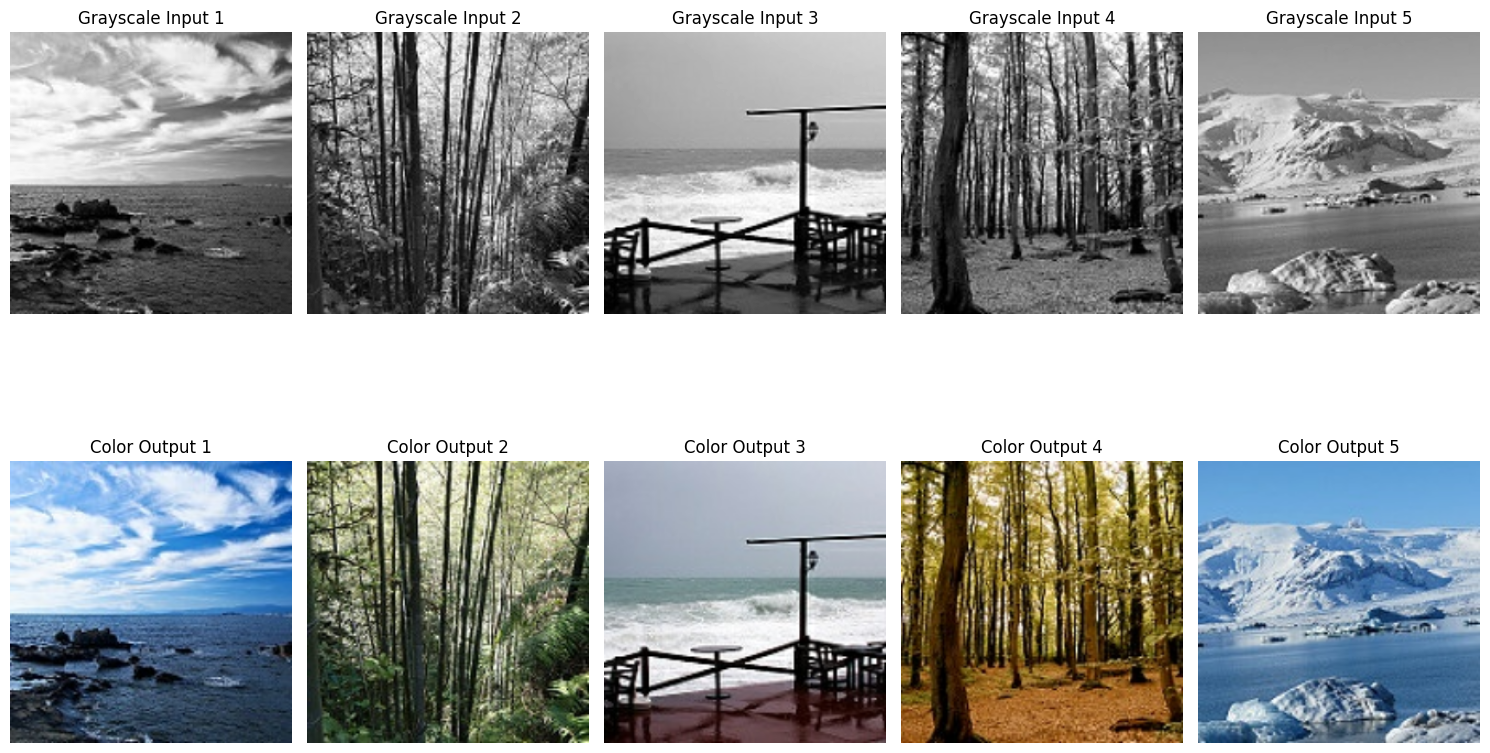

Test Set Samples:


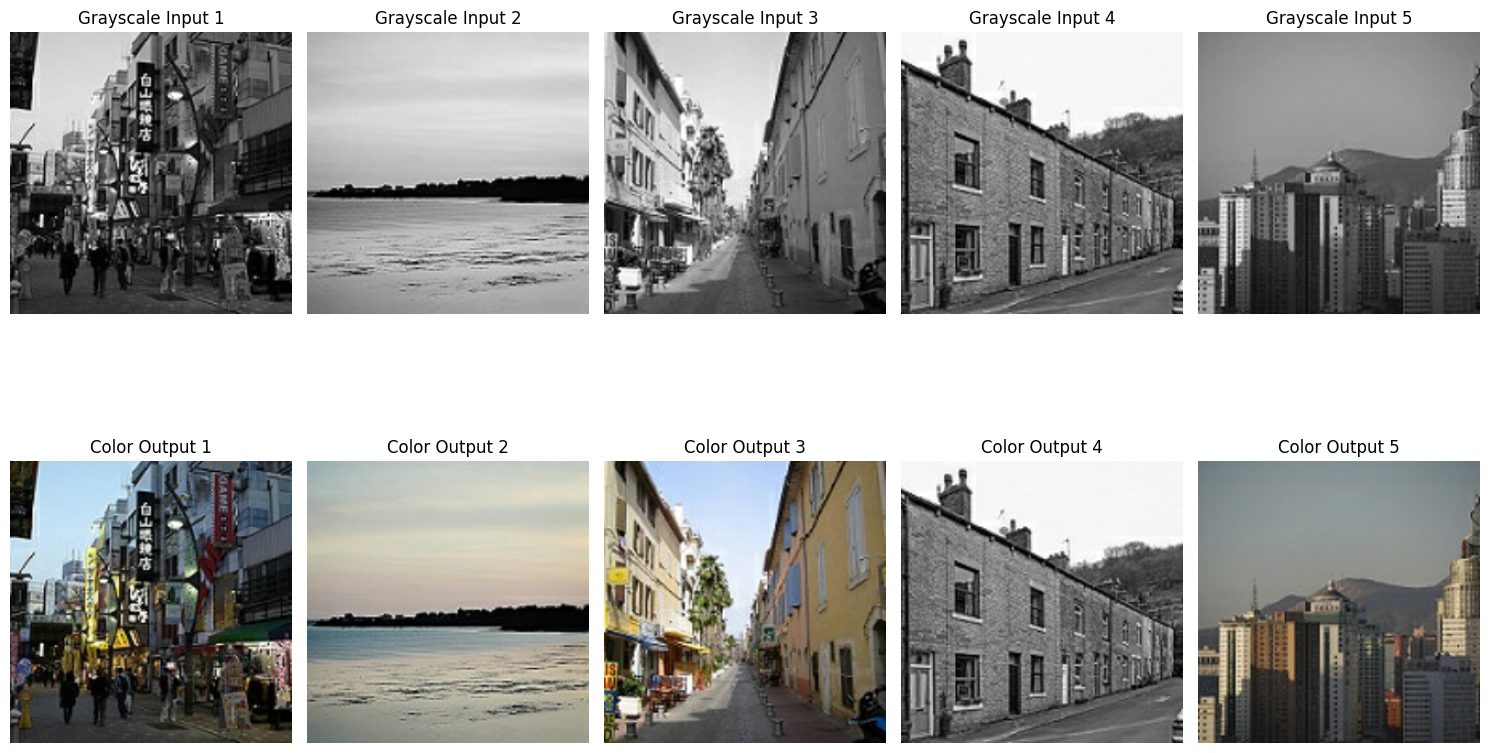

In [ ]:
# Plot 5 pairs from each set to validate
print("Training Set Samples:")
plot_image_pairs(train_ds, num_pairs=5)

print("Validation Set Samples:")
plot_image_pairs(val_ds, num_pairs=5)

print("Test Set Samples:")
plot_image_pairs(test_ds, num_pairs=5)

# Understanding the pix2pix Model: A Deep Dive into GANs and Its Components

## What is a GAN?

A Generative Adversarial Network (GAN) is a class of machine learning frameworks where two neural networks, the **generator** and the **discriminator**, are trained simultaneously in a competitive setting. Introduced by Ian Goodfellow in 2014, GANs aim to generate data (e.g., images) that is indistinguishable from real data. The generator creates fake data, while the discriminator evaluates whether the data is real or fake. Through this adversarial process, the generator improves its ability to produce realistic outputs.

The core idea is a zero-sum game: the generator tries to fool the discriminator, and the discriminator tries to correctly distinguish real from fake. This competition drives both networks to improve until the generator produces highly realistic results.

## Types of GANs

Several types of GANs have been developed, each with specific applications and improvements:

- **Vanilla GAN**: The original GAN, where the generator produces random samples (e.g., images) and the discriminator classifies them as real or fake. No conditional information is used.

- **Conditional GAN (cGAN)**: Extends GANs by conditioning both the generator and discriminator on additional information (e.g., labels or images), enabling controlled generation. Pix2pix is a prominent example of a cGAN.

- **Deep Convolutional GAN (DCGAN)**: Uses convolutional layers to improve the quality of generated images, making them sharper and more detailed.

- **CycleGAN**: Focuses on unpaired image-to-image translation, allowing transformation between domains (e.g., horses to zebras) without paired examples.

- **StyleGAN**: Generates high-quality images with control over style and features, often used in face generation.

- **Wasserstein GAN (WGAN)**: Improves training stability by using the Wasserstein distance instead of the original GAN loss, reducing mode collapse.

Among these, **Conditional GANs (cGANs)** are particularly relevant for tasks like image colorization, as they allow the model to generate outputs conditioned on specific inputs.

## Deep Dive into Conditional GANs (cGANs)

Conditional GANs enhance traditional GANs by incorporating conditional information, such as an input image or label, into both the generator and discriminator. This conditioning enables the model to produce targeted outputs, making cGANs ideal for image-to-image translation tasks like converting grayscale images to colored versions.

In a cGAN, the generator $G$ takes both a noise vector $z$ and a condition $x$ (e.g., a grayscale image) to produce an output $G(z, x)$, while the discriminator $D$ evaluates pairs of real data $x$ (condition) and $y$ (target, e.g., colored image) or fake data $x$ and $G(z, x)$. The objective is to minimize the following loss:

$$L_{cGAN}(G, D) = E_{x, y}[\log D(x, y)] + E_{x, z}[\log(1 - D(x, G(z, x)))]$$

Here, $E$ denotes expectation, $x$ is the condition (e.g., grayscale), $y$ is the real target (e.g., color), and $z$ is random noise. The generator aims to minimize this loss, while the discriminator maximizes it, creating a min-max game.

Pix2pix is a specific implementation of a cGAN, designed for paired image-to-image translation, such as turning grayscale images into colored ones. It uses a deterministic approach, where the condition (grayscale image) directly guides the generation, often eliminating the need for random noise $z$ in many cases.

## Components of pix2pix

Pix2pix consists of two main parts: the **generator** and the **discriminator**. Each has a specialized architecture to handle the image-to-image translation task.

### 1. Generator

The generator in pix2pix is responsible for transforming the input grayscale image into a colored output. It uses a **U-Net** architecture, which is particularly effective for preserving spatial details.

- **U-Net Architecture**: U-Net is an encoder-decoder network with skip connections. The encoder compresses the input (grayscale image) into a lower-dimensional representation, capturing high-level features, while the decoder reconstructs the output (colored image) at the same resolution. Skip connections bridge the encoder and decoder, allowing low-level spatial information (e.g., edges) to be preserved.

  The U-Net structure can be visualized as:

  - **Encoder**: Convolutional layers with downsampling (e.g., max pooling or strided convolutions) to reduce spatial dimensions.
  - **Decoder**: Transposed convolutions or upsampling to increase spatial dimensions, combined with skip connections from the encoder.
  - **Output**: Produces a colored image with three channels (RGB).

  This design ensures that fine details from the grayscale input are retained in the colorized output, making it ideal for images where texture and structure are important.

### 2. Discriminator

The discriminator in pix2pix evaluates whether the generated colored image, paired with its grayscale input, is realistic compared to real colored images. It uses a **PatchGAN** architecture, which classifies local patches of the image rather than the entire image.

- **PatchGAN Architecture**: Instead of outputting a single value (real or fake), PatchGAN outputs a matrix of values, where each value corresponds to whether a patch of the image is realistic. This approach captures local details and enforces consistency across the image.

  - **Input**: Takes a pair of images (grayscale input and either real or generated colored output).
  - **Output**: A matrix where each element indicates the realism of a corresponding patch, averaged to produce a final realism score.

  This patch-based approach is particularly effective for high-resolution image tasks, as it ensures that the generator produces locally coherent and visually plausible results.

first, let's define two helper methods:

- **Downsample**: Reduces the spatial dimensions of an input tensor (e.g., an image) while increasing the number of channels (feature depth). This is typically done using a convolutional layer with a stride of 2 or max pooling. For an input tensor $X$ of shape $(H, W, C)$, downsampling produces an output of shape $(H/2, W/2, C')$ where $C' > C$.

- **Upsample**: Increases the spatial dimensions of an input tensor while decreasing the number of channels, used in the decoder to reconstruct the output. This is typically achieved with transposed convolutions (deconvolutions) or upsampling followed by convolution. For an input tensor $Y$ of shape $(H, W, C)$, upsampling produces an output of shape $(2H, 2W, C')$ where $C' < C$.

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                                    kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def build_generator():
    """
    Build a fully convolutional U-Net generator for pix2pix, accepting arbitrary input sizes.

    Returns:
        tf.keras.Model: U-Net generator model.
    """
    inputs = tf.keras.layers.Input(shape=[None, None, 1])  # Arbitrary height and width, 1 channel (grayscale)

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, H/2, W/2, 64) where H, W are input dimensions
        downsample(128, 4),  # (bs, H/4, W/4, 128)
        downsample(256, 4),  # (bs, H/8, W/8, 256)
        downsample(512, 4),  # (bs, H/16, W/16, 512)
        downsample(512, 4),  # (bs, H/32, W/32, 512)
        downsample(512, 4),  # (bs, H/64, W/64, 512)
        downsample(512, 4),  # (bs, H/128, W/128, 512)
        downsample(512, 4),  # (bs, H/256, W/256, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, H/128, W/128, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, H/64, W/64, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, H/32, W/32, 1024)
        upsample(512, 4),  # (bs, H/16, W/16, 1024)
        upsample(256, 4),  # (bs, H/8, W/8, 512)
        upsample(128, 4),  # (bs, H/4, W/4, 256)
        upsample(64, 4),  # (bs, H/2, W/2, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (bs, 2H, 2W, 3) for final upsampling

    x = inputs

    # Downsampling through the model, storing skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name='U_net_generator')

Model: "U_net_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, None, None, 64) │          1,024 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, None, None,     │        131,584 │ sequential[0][0]       │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, None, None,     │        525,312 │ sequential_1[0][0]     │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, None, None,     │      2,099,200 │ sequential_2[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_3[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_4[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_5[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_6[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, None, None,     │      4,196,352 │ sequential_7[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, None,     │              0 │ sequential_8[0][0],    │
│                           │ 1024)                  │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, None, None,     │      8,390,656 │ concatenate[0][0]      │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, None, None,     │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │ 1024)                  │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, None, None,     │      8,390,656 │ concatenate_1[0][0]    │
│ (Sequential)         

 Total params: 54,423,811 (207.61 MB)

 Trainable params: 54,412,931 (207.57 MB)

 Non-trainable params: 10,880 (42.50 KB)

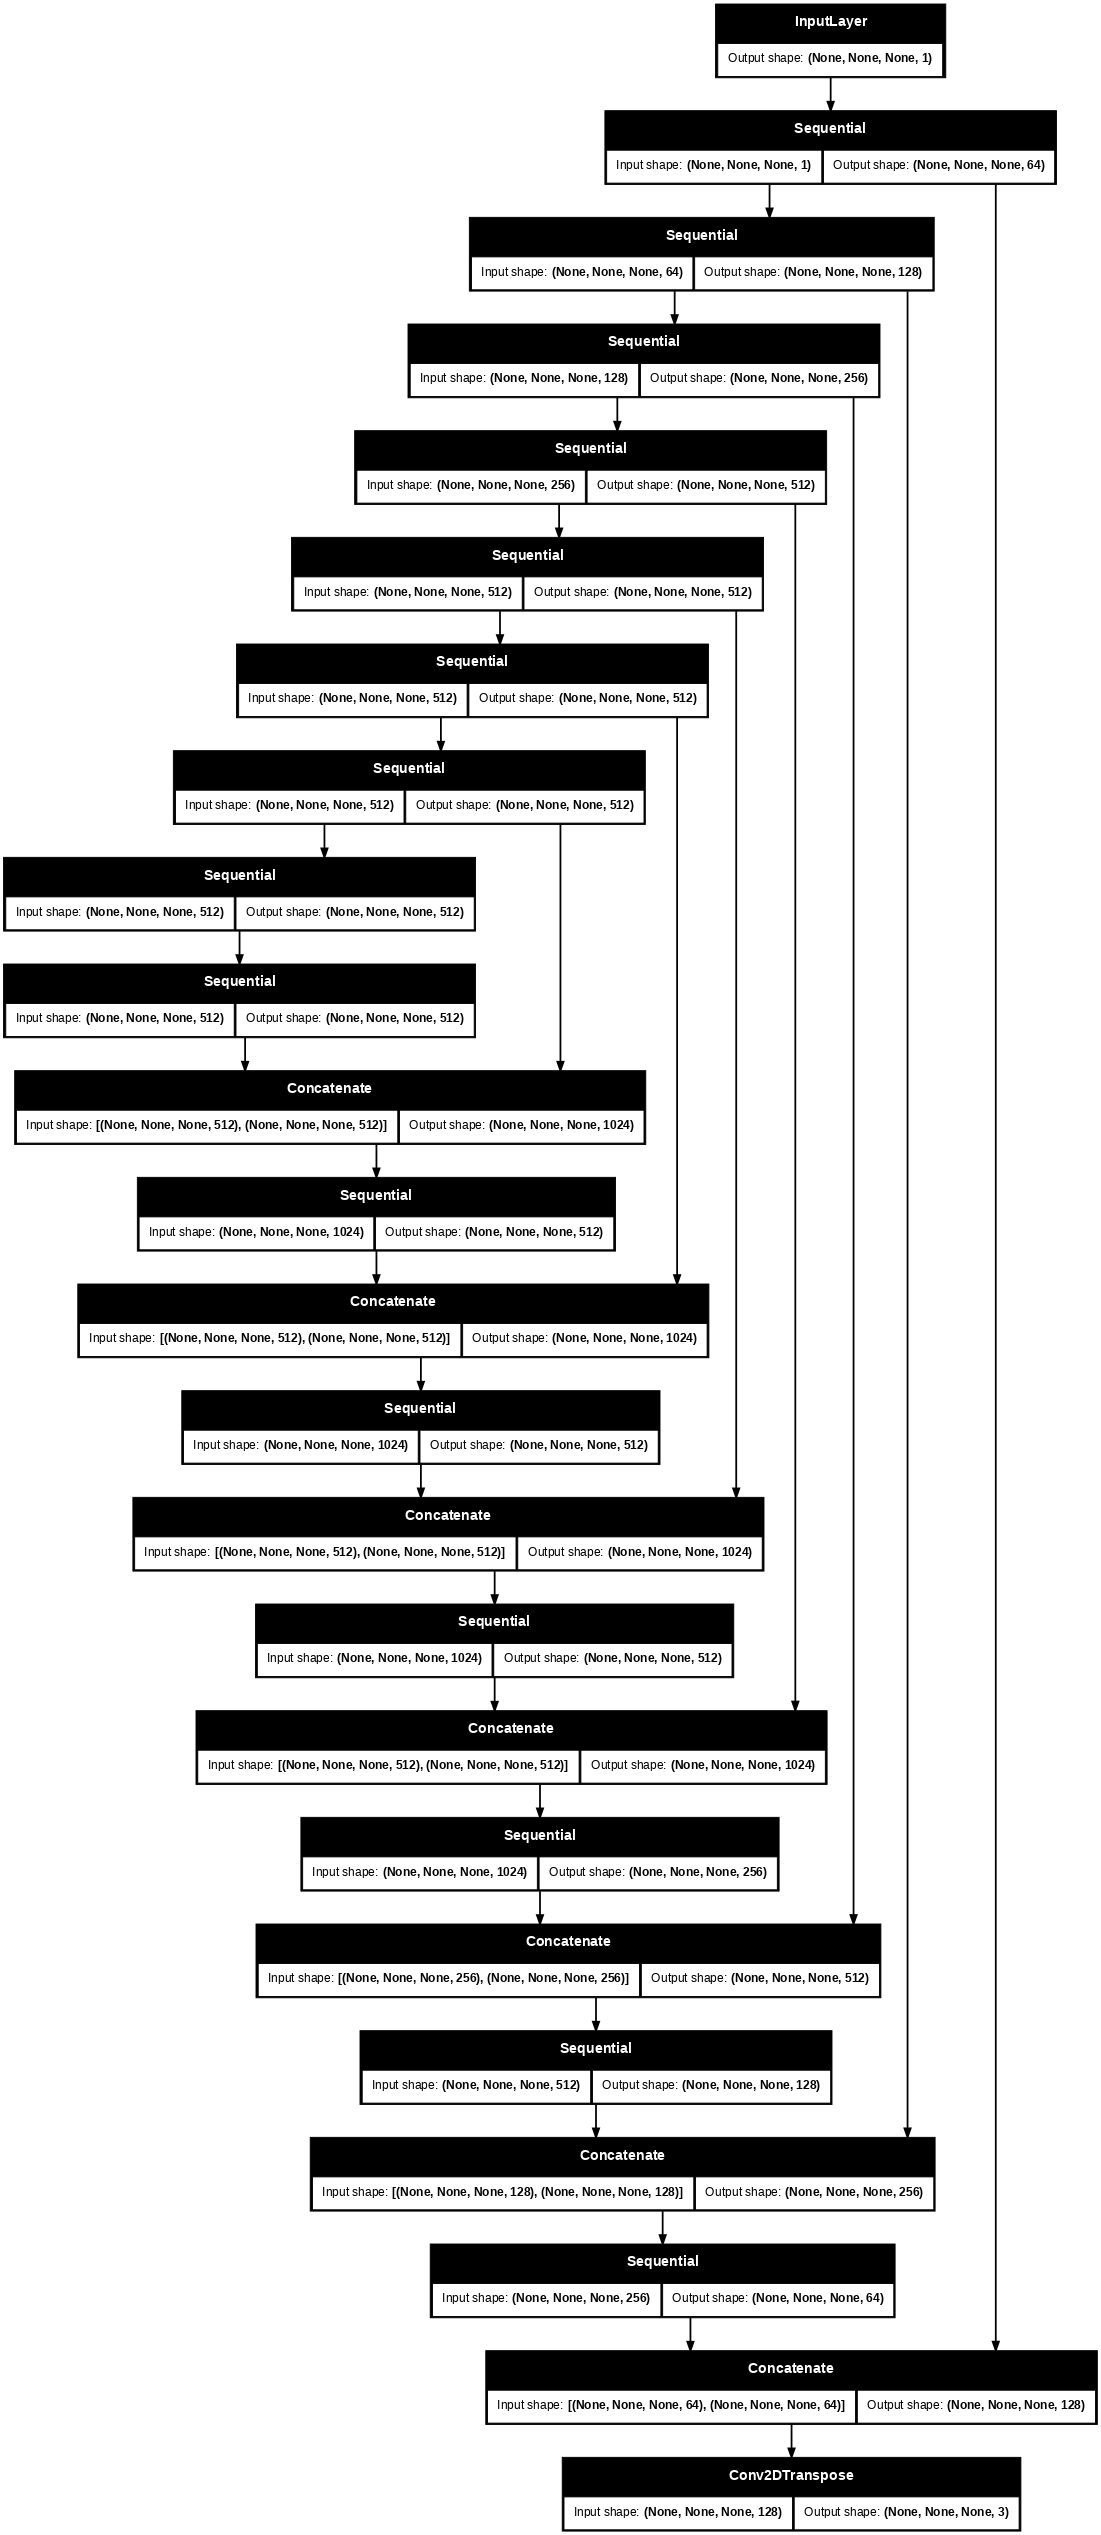

In [ ]:
generator = build_generator()
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
layered_view(model, to_file='generator.png', legend=True, max_xy=500)

### 2. Discriminator

The discriminator in pix2pix, called **PatchGAN**, evaluates whether patches of the generated image are realistic compared to real colored images. Unlike a traditional GAN discriminator that outputs a single scalar (real or fake), PatchGAN outputs a matrix of values, where each value corresponds to a patch of the image.

- **PatchGAN Architecture**: PatchGAN divides the image into smaller patches (e.g., 70x70 pixels) and classifies each patch as real or fake. This approach focuses on local realism rather than global coherence, which is efficient for high-resolution images like landscapes.

  The PatchGAN discriminator uses convolutional layers to process the concatenated input (grayscale and colored image) and outputs a map where each element indicates the realism of the corresponding patch. The final decision is often averaged over all patches.

In [ ]:
def build_discriminator():
    """
    Build a fully convolutional PatchGAN discriminator for pix2pix, accepting arbitrary input sizes.

    Returns:
        tf.keras.Model: PatchGAN discriminator model.
    """
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')  # Arbitrary height and width, 1 channel (grayscale)
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')  # Arbitrary height and width, 3 channels (color)

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, H, W, 4) where H, W are input dimensions

    down1 = downsample(64, 4, False)(x)  # (bs, H/2, W/2, 64)
    down2 = downsample(128, 4)(down1)  # (bs, H/4, W/4, 128)
    down3 = downsample(256, 4)(down2)  # (bs, H/8, W/8, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, H/8+2, W/8+2, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1)  # (bs, H/8-1, W/8-1, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, H/8+1, W/8+1, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2)  # (bs, H/8-2, W/8-2, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last, name='PatchGAN_Discriminator')

Model: "PatchGAN_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, None, None, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, None, None, 4)  │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, None, None, 64) │          4,096 │ concatenate_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, None, None,     │        131,584 │ sequential_15[0][0]    │
│ (Sequential)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, None, None,     │        525,312 │ sequential_16[0][0]    │
│ (Sequential)              │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, None, None,     │              0 │ sequential_17[0][0]    │
│ (ZeroPadding2D)           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, None, None,     │      2,097,152 │ zero_padding2d[0][0]   │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, None, None,     │          2,048 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, None, None,     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, None, None,     │              0 │ leaky_re_lu_11[0][0]   │
│ (ZeroPadding2D)           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, None, None, 1)  │          8,193 │ zero_padding2d_1[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,768,385 (10.56 MB)

 Trainable params: 2,766,593 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

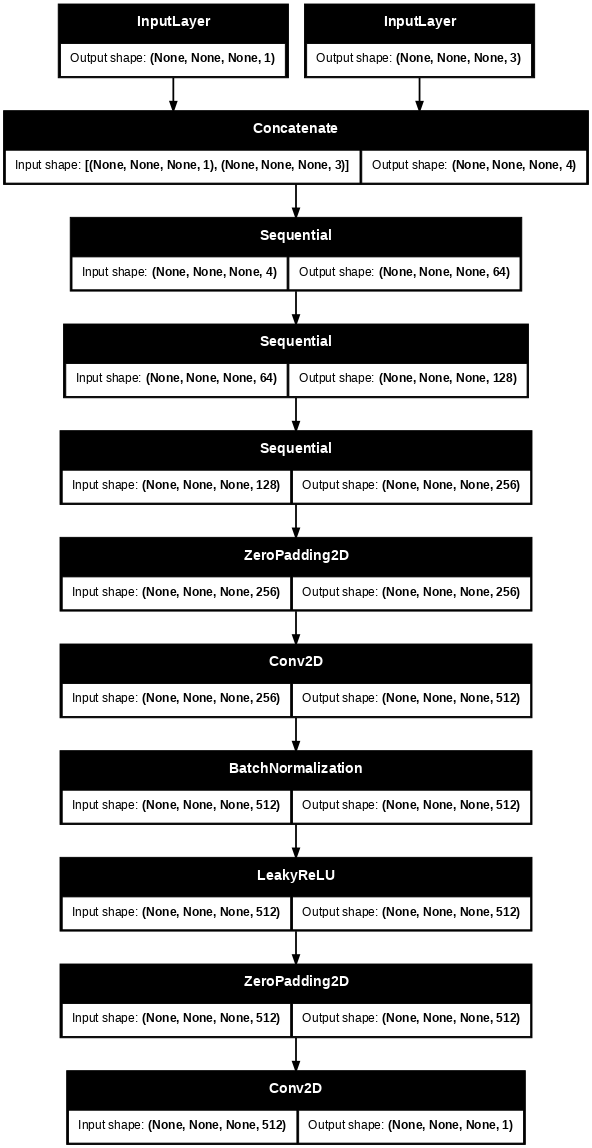

In [ ]:
discriminator = build_discriminator()
discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## Fully Convolutional Design

To make the pix2pix model fully convolutional, we set the input size of both the generator and discriminator to `None`. This allows the networks to accept images of arbitrary spatial dimensions (e.g., height and width), making them flexible for different input sizes while maintaining their ability to process features hierarchically.

## Why Fully Convolutional?

By removing fixed input dimensions, the model can handle the 150x150 images from the Landscape-Image-Colorization dataset, as well as larger or smaller images, without retraining or resizing. This is particularly useful for ensuring the model generalizes across varying resolutions, such as when scaling up for better detail or adapting to new datasets.

### Loss Functions

Pix2pix combines two loss functions to train the generator and discriminator effectively:

- **Adversarial Loss (cGAN Loss)**: Ensures the generated images are realistic. For the discriminator, it maximizes:

$$L_D = -E_{x, y}[\log D(x, y)] - E_{x}[\log(1 - D(x, G(x)))]$$

For the generator, it minimizes:

$$L_G^{adv} = -E_{x}[\log(D(x, G(x)))]$$

This pushes the generator to fool the discriminator.

- **L1 Loss (Reconstruction Loss)**: Ensures the generated image is close to the ground truth. It is defined as:

$$L_{L1} = E_{x, y}[||y - G(x)||_1]$$

This encourages pixel-wise accuracy, which is crucial for tasks like colorization where exact matches matter.

The total generator loss is a weighted sum:

$$L_{G} = L_G^{adv} + \lambda L_{L1}$$

where $\lambda$ is a hyperparameter (typically 100) that balances the adversarial and reconstruction losses.

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Training Process

The training process of pix2pix involves alternating updates to the generator and discriminator:

1. **Initialization**: Initialize the U-Net generator and PatchGAN discriminator with random weights.

2. **Data Preparation**: Load paired grayscale and colored landscape images, normalize them to [0, 1], and create batches.

3. **Forward Pass**:
   - The generator $G$ takes a grayscale image $x$ and produces a fake colored image $G(x)$.
   - The discriminator $D$ evaluates real pairs $(x, y)$ (grayscale and true color) and fake pairs $(x, G(x))$ (grayscale and generated color).

4. **Loss Computation**:
   - Compute the adversarial loss for both $G$ and $D$ using the cGAN loss.
   - Compute the L1 loss between the generated image $G(x)$ and the real colored image $y$.

5. **Backpropagation**:
   - Update the discriminator $D$ to maximize its ability to distinguish real from fake (minimize $L_D$).
   - Update the generator $G$ to minimize the combined loss $L_G = L_G^{adv} + \lambda L_{L1}$, improving its ability to generate realistic and accurate colored images.

6. **Iteration**: Repeat for multiple epochs, typically using a large dataset and adjusting hyperparameters (e.g., learning rate, $\lambda$) to balance realism and accuracy.

7. **Convergence**: Training continues until the generator produces colored images that the discriminator can no longer reliably distinguish from real ones, and the L1 loss is minimized for fidelity.

This adversarial training process ensures that pix2pix learns to colorize landscapes effectively, balancing global realism (via the discriminator) and local detail (via the generator and L1 loss).

In [ ]:
# configuration
GENERATOR_LR_INIT = 2e-4 # Initial LR
DISCRIMINATOR_LR_INIT = 2e-4 # Initial LR
ADAM_BETA_1 = 0.5
SAVE_DIR = 'pix2pix_checkpoints_minimal'
EARLY_STOPPING_MONITOR = 'val_gen_l1_loss' # Default metric to monitor

In [ ]:
# --- Main Training Function ---

def train_pix2pix(
    train_ds,
    epochs,
    validation_ds=None,
    generator_in=None,
    discriminator_in=None,
    early_stopping_patience=None,
    lr_decay_patience=None,
    lr_decay_factor=0.5,
    min_lr=1e-7
):
    """
    Trains a Pix2Pix model with validation, early stopping, and LR decay.

    Args:
        train_ds: tf.data.Dataset for training.
        epochs: Number of training epochs.
        validation_ds: Optional tf.data.Dataset for validation.
        generator_in: Optional pre-existing generator model.
        discriminator_in: Optional pre-existing discriminator model.
        early_stopping_patience: Int or None. Patience for stopping training early.
        lr_decay_patience: Int or None. Patience (epochs without improvement)
                           before decaying learning rate. Requires validation_ds.
        lr_decay_factor: Factor to multiply learning rate by upon decay.
        min_lr: The minimum learning rate allowed after decay.

    Returns:
        Tuple: (trained_generator, trained_discriminator) after training/loading best.
    """

    print("--- Pix2Pix Training Setup ---")
    # Models
    generator = build_generator() if generator_in is None else generator_in
    discriminator = build_discriminator() if discriminator_in is None else discriminator_in
    print(f"Using {'new' if generator_in is None else 'provided'} generator, "
          f"{'new' if discriminator_in is None else 'provided'} discriminator.")

    # Optimizers - use initial LRs
    generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR_INIT, beta_1=ADAM_BETA_1)
    discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR_INIT, beta_1=ADAM_BETA_1)
    print(f"Optimizers: Adam (Initial Gen LR={GENERATOR_LR_INIT:.1e}, "
          f"Initial Disc LR={DISCRIMINATOR_LR_INIT:.1e}, Beta1={ADAM_BETA_1})")

    # --- Validation, Saving, Stopping, LR Decay Setup ---
    metric_key_to_monitor = EARLY_STOPPING_MONITOR
    perform_validation = validation_ds is not None

    if perform_validation and metric_key_to_monitor == 'val_disc_loss':
         print(f"Warning: Monitoring 'val_disc_loss' is disabled. Defaulting to 'val_gen_l1_loss'.")
         metric_key_to_monitor = 'val_gen_l1_loss' # Discriminator loss isn't calculated in validation

    perform_early_stopping = early_stopping_patience is not None and perform_validation
    perform_lr_decay = lr_decay_patience is not None and perform_validation

    print(f"Saving best models to: {SAVE_DIR}")
    if perform_validation:
        print(f"Monitoring metric for improvements: '{metric_key_to_monitor}'")
    if early_stopping_patience:
        print(f"Early stopping patience: {early_stopping_patience} epochs" if perform_early_stopping else \
              "Early stopping requires validation_ds to be active.")
    if lr_decay_patience:
        print(f"LR decay patience: {lr_decay_patience} epochs (factor={lr_decay_factor}, min_lr={min_lr:.1e})" if perform_lr_decay else \
              "LR decay requires validation_ds to be active.")


    best_gen_weights_path = os.path.join(SAVE_DIR, 'best_generator.weights.h5')
    best_disc_weights_path = os.path.join(SAVE_DIR, 'best_discriminator.weights.h5')
    os.makedirs(SAVE_DIR, exist_ok=True)

    best_metric_value = np.inf # Lower is better for typical loss metrics
    epochs_no_improve = 0
    best_epoch = 0

    # --- tf.function definitions for performance ---
    @tf.function
    def train_step_internal(input_image, target):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, target
            )
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        return gen_gan_loss, gen_l1_loss, disc_loss

    @tf.function
    def validation_step_internal(input_image, target):
        gen_output = generator(input_image, training=False)
        disc_generated_output = discriminator([input_image, gen_output], training=False)
        # Calculate only generator loss components needed for monitoring
        _, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        # Return only generator losses (no discriminator loss calculated/returned)
        return gen_gan_loss, gen_l1_loss

    # --- Training Loop ---
    print(f"\n--- Starting Training ({epochs} epochs) ---")
    num_train_batches_total = tf.data.experimental.cardinality(train_ds).numpy()
    if num_train_batches_total in [-1, -2]: # UNKNOWN or INFINITE cardinality
        print("Training dataset size unknown or infinite, progress bar may lack ETA.")
        num_train_batches_total = None

    training_completed_epochs = 0 # Track actual epochs run
    for epoch in range(epochs):
        start_time = time.time()
        training_completed_epochs = epoch + 1

        # --- Training Phase ---
        epoch_train_metrics = {'gen_gan_loss': 0.0, 'gen_l1_loss': 0.0, 'disc_loss': 0.0}
        progbar = tf.keras.utils.Progbar(num_train_batches_total, stateful_metrics=['epoch','gen_gan_loss', 'gen_l1_loss', 'disc_loss'])
        actual_train_batches = 0
        progbar.update(0, values=[('epoch', epoch + 1)]) # Show epoch number immediately

        for batch_idx, (input_image, target) in enumerate(train_ds):
            gen_gan_loss, gen_l1_loss, disc_loss = train_step_internal(input_image, target)
            actual_train_batches += 1
            metrics_values = [
                ('epoch', epoch + 1),
                ("gen_gan_loss", float(gen_gan_loss)),
                ("gen_l1_loss", float(gen_l1_loss)),
                ("disc_loss", float(disc_loss))
            ]
            progbar.update(batch_idx + 1, values=metrics_values)
            # Accumulate for epoch average
            epoch_train_metrics['gen_gan_loss'] += float(gen_gan_loss)
            epoch_train_metrics['gen_l1_loss'] += float(gen_l1_loss)
            epoch_train_metrics['disc_loss'] += float(disc_loss)

        if actual_train_batches > 0:
            for key in epoch_train_metrics:
                epoch_train_metrics[key] /= actual_train_batches
        else:
             print("Warning: No training batches were processed in this epoch.")

        # --- Validation Phase ---
        epoch_val_metrics = {'val_gen_gan_loss': 0.0, 'val_gen_l1_loss': 0.0} # No val_disc_loss
        actual_val_batches = 0
        final_display_metrics = [('epoch', epoch + 1)]
        final_display_metrics.extend([(k, v) for k, v in epoch_train_metrics.items()]) # Add avg train metrics

        if perform_validation:
            for input_image, target in validation_ds:
                 val_gen_gan_loss, val_gen_l1_loss = validation_step_internal(input_image, target)
                 epoch_val_metrics['val_gen_gan_loss'] += float(val_gen_gan_loss)
                 epoch_val_metrics['val_gen_l1_loss'] += float(val_gen_l1_loss)
                 actual_val_batches += 1

            if actual_val_batches > 0:
                for key in epoch_val_metrics:
                    epoch_val_metrics[key] /= actual_val_batches
            else:
                print("Warning: No validation batches processed.")
                for key in epoch_val_metrics: epoch_val_metrics[key] = None # Indicate missing data

            # Add calculated average validation metrics for final display
            final_display_metrics.extend([(k, v) for k, v in epoch_val_metrics.items()])

        # Finalize progress bar for the epoch with all metrics
        progbar.update(actual_train_batches, values=final_display_metrics, finalize=True)

        # --- Checkpointing, Early Stopping, and LR Decay ---
        current_metric_value = np.inf # Default if not available

        if perform_validation:
            current_metric_value = epoch_val_metrics.get(metric_key_to_monitor)
            if current_metric_value is None:
                 print(f"Warning: Monitored metric '{metric_key_to_monitor}' value not available this epoch.")
                 current_metric_value = np.inf # Treat missing metric as no improvement

        # Compare metric and save/update counters
        if current_metric_value < best_metric_value:
            # Improved: Save weights, reset patience counter
            print(f"\n  >> Metric ({metric_key_to_monitor}) improved: {best_metric_value:.4f} -> {current_metric_value:.4f}. Saving models...")
            best_metric_value = current_metric_value
            generator.save_weights(best_gen_weights_path)
            discriminator.save_weights(best_disc_weights_path)
            epochs_no_improve = 0
            best_epoch = epoch + 1
            print() # Add newline for better spacing
        elif perform_validation: # Only increment counters if validation is active
            epochs_no_improve += 1
            # Print patience status only if validation/stopping/decay are active
            patience_info = []
            if perform_early_stopping: patience_info.append(f"Stop Patience: {epochs_no_improve}/{early_stopping_patience}")
            if perform_lr_decay: patience_info.append(f"LR Decay Patience: {epochs_no_improve % lr_decay_patience if lr_decay_patience > 0 else epochs_no_improve}/{lr_decay_patience}")

            if patience_info:
                 print(f"\n  >> Metric did not improve. ({', '.join(patience_info)})\n")

            # --- LEARNING RATE DECAY ---
            if perform_lr_decay and (epochs_no_improve % lr_decay_patience == 0) and epochs_no_improve > 0 :
                current_gen_lr = generator_optimizer.learning_rate.numpy()
                current_disc_lr = discriminator_optimizer.learning_rate.numpy()

                new_gen_lr = max(current_gen_lr * lr_decay_factor, min_lr)
                new_disc_lr = max(current_disc_lr * lr_decay_factor, min_lr)

                lr_updated = False
                if new_gen_lr < current_gen_lr:
                    generator_optimizer.learning_rate.assign(new_gen_lr)
                    lr_updated = True
                if new_disc_lr < current_disc_lr:
                    discriminator_optimizer.learning_rate.assign(new_disc_lr)
                    lr_updated = True

                if lr_updated:
                    print(f"  >> Decaying learning rate after {epochs_no_improve} epochs of no improvement.")
                    print(f"     Gen LR: {current_gen_lr:.1e} -> {generator_optimizer.learning_rate.numpy():.1e}")
                    print(f"     Disc LR: {current_disc_lr:.1e} -> {discriminator_optimizer.learning_rate.numpy():.1e}\n")

        # --- Early Stopping Check ---
        if perform_early_stopping and epochs_no_improve >= early_stopping_patience:
            print(f"-- Early stopping triggered after epoch {epoch + 1} --")
            print(f"   Best metric ({metric_key_to_monitor}): {best_metric_value:.4f} achieved at epoch {best_epoch}.")
            break # Exit the main training loop

    # --- End of Training Loop ---
    print(f"\n--- Training Finished ({training_completed_epochs}/{epochs} epochs completed) ---")

    # --- Load Best Weights back into models ---
    if perform_validation and best_epoch > 0: # Check if improvement ever occurred
        if os.path.exists(best_gen_weights_path) and os.path.exists(best_disc_weights_path):
            print(f"Loading best weights from epoch {best_epoch} (Metric: {best_metric_value:.4f})...")
            try:
                generator.load_weights(best_gen_weights_path)
                discriminator.load_weights(best_disc_weights_path)
                print("Best weights loaded successfully.")
            except Exception as e:
                print(f"Warning: Error loading best weights from {SAVE_DIR}. Models retain last epoch weights. Error: {e}")
        else:
             print(f"Warning: Best weight files not found at {SAVE_DIR}. Models retain last epoch weights.")
    else:
         # Handles cases: no validation, or no improvement ever occurred, or training stopped early before saving
         if training_completed_epochs > 0:
             print("Models retain weights from the last training epoch" +
                   (" (no improvement detected)." if perform_validation and best_epoch == 0 else "."))


    return generator, discriminator

The `train_pix2pix` function automates the training process for the image colorization model using pix2pix, enabling it to learn how to transform grayscale images into colored versions. It ensures that the training is efficient, monitorable, and adaptable, making it suitable for experimentation and practical application. The function handles the entire training workflow, from initializing models and optimizers to managing progress, validation, and model improvements.

### What It Does

- **Trains Models**: It trains both the generator (which creates colored images from grayscale inputs) and the discriminator (which evaluates whether the generated images are realistic) using a prepared dataset of images. The training process adjusts these models over multiple epochs to improve their performance on the colorization task.

- **Supports Validation**: If provided with validation data, the function periodically checks the model’s performance on unseen data to ensure it generalizes well. This helps assess how effectively the model can colorize new images, not just those it has seen during training.

- **Implements Early Stopping**: The function can automatically stop training early if the model’s performance on the validation data stops improving for a specified period. This prevents wasting computational resources and avoids overfitting, ensuring the model retains its ability to generalize.

- **Adjusts Learning Rate**: It dynamically reduces the learning rate (the step size for updating model weights) if the model’s performance plateaus, helping it fine-tune more slowly and potentially escape local optima. This adjustment ensures continued progress even as training becomes more challenging.

- **Saves Best Models**: During training, the function saves the best versions of the generator and discriminator models based on their performance on the validation data. At the end, it loads these best models, ensuring that the final output represents the peak performance achieved.

- **Provides Feedback**: It offers detailed feedback throughout the training process, such as progress updates, metric improvements, and warnings about potential issues (e.g., missing validation data). This feedback helps users monitor how well the training is progressing and make informed decisions.

- **Optimizes Performance**: The function uses efficient techniques to speed up training, such as batch processing and prefetching, ensuring that it can handle large datasets like the Landscape-Image-Colorization dataset effectively.

In [ ]:
generator, discriminator = train_pix2pix(train_ds,200, validation_ds=val_ds, early_stopping_patience=30, lr_decay_patience=5)

--- Pix2Pix Training Setup ---
Using new generator, new discriminator.
Optimizers: Adam (Initial Gen LR=2.0e-04, Initial Disc LR=2.0e-04, Beta1=0.5)
Saving best models to: pix2pix_checkpoints_minimal
Monitoring metric for improvements: 'val_gen_l1_loss'
Early stopping patience: 30 epochs
LR decay patience: 5 epochs (factor=0.5, min_lr=1.0e-07)

--- Starting Training (200 epochs) ---
88/88 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - epoch: 1.0000 - gen_gan_loss: 1.1011 - gen_l1_loss: 0.0730 - disc_loss: 1.5401 
88/88 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - epoch: 1.0000 - gen_gan_loss: 0.9498 - gen_l1_loss: 0.1023 - disc_loss: 1.3617 - val_gen_gan_loss: 0.2860 - val_gen_l1_loss: 0.1439

  >> Metric (val_gen_l1_loss) improved: inf -> 0.1439. Saving models...

88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 960ms/step - epoch: 2.0000 - gen_gan_loss: 0.9983 - gen_l1_loss: 0.0598 - disc_loss: 1.2757
88/88 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - epoch: 2.0000 - gen_gan_loss: 0.9354 - gen_l1_loss: 0.0621 - disc_loss: 1.2122 

In [ ]:
def test_generator(
    generator,
    test_dataset,
    num_samples = 3
):

    unbatched_dataset = test_dataset.unbatch()
    sampled_data_list = list(unbatched_dataset.take(num_samples).as_numpy_iterator())
    actual_num_samples = len(sampled_data_list)

    if actual_num_samples == 0:
        print("Error: Could not retrieve any samples from the dataset. "
              "Check if the dataset is empty or if .take() failed.")
        return

    if actual_num_samples < num_samples:
        print(f"Warning: Requested {num_samples} samples, but dataset only yielded {actual_num_samples}.")
        num_samples = actual_num_samples

    grayscale_samples = [item[0] for item in sampled_data_list]
    colored_samples_gt = [item[1] for item in sampled_data_list]
    grayscale_batch = tf.stack([tf.cast(img, tf.float32) for img in grayscale_samples])
    generated_samples_raw = generator(grayscale_batch, training=False)

    generated_samples = tf.cast(generated_samples_raw, tf.float32)
    generated_samples = tf.clip_by_value(generated_samples, 0.0, 1.0)

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 2.5 * num_samples))

    if num_samples == 1:
        axes_flat = [axes]
    else:
        axes_flat = axes

    for i in range(num_samples):
        current_axes = axes_flat[i]

        ax_input = current_axes[0]
        ax_input.imshow(grayscale_samples[i].squeeze(), cmap='gray')
        ax_input.set_title("Grayscale Input")
        ax_input.axis("off")

        ax_gen = current_axes[1]
        gen_img_np = generated_samples[i].numpy()
        ax_gen.imshow(gen_img_np)
        ax_gen.set_title("Generated Colorized")
        ax_gen.axis("off")

        ax_gt = current_axes[2]
        gt_img = colored_samples_gt[i]
        if hasattr(gt_img, 'numpy'):
             gt_img_np = gt_img.numpy()
        else:
             gt_img_np = gt_img
        gt_img_np = tf.clip_by_value(gt_img_np, 0.0, 1.0)
        ax_gt.imshow(gt_img_np)
        ax_gt.set_title("Ground Truth Color")
        ax_gt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
test_generator(generator, test_ds, num_samples=30)

## Evaluation Metrics for Image Colorization

When generating color images from grayscale inputs, it’s important to measure how close the generated images are to the real ones. Two common metrics used for this are:

### PSNR (Peak Signal-to-Noise Ratio)

**What it is**: PSNR measures the difference between the pixel values of the generated image and the ground truth, expressed in decibels (dB).

#### Why we use it:

- Higher PSNR means the generated image is closer to the original (less error).
- Simple and widely used for measuring image quality in tasks like denoising, compression, and reconstruction.

PSNR is sensitive to small pixel-level differences but doesn’t always reflect perceptual quality.

### SSIM (Structural Similarity Index)

**What it is**: SSIM compares the structure, contrast, and luminance of two images. It returns a score between -1 and 1, where 1 means perfect similarity.

#### Why we use it:

- SSIM is more aligned with human visual perception.
- Captures the structural fidelity of the image, not just pixel-wise differences.
- Useful for assessing visual quality in tasks like super-resolution and colorization.

### Why Both?

Using both PSNR and SSIM gives a more complete picture:

- PSNR checks numerical similarity.
- SSIM checks perceptual similarity.

This dual approach ensures that generated images are not only mathematically close to the originals but also look right to human observers, providing a balanced assessment of the model’s performance.

In [ ]:
def evaluate_dataset(generator, dataset):
    total_psnr = 0
    total_ssim = 0
    num_batches = 0

    for grayscale_batch, colored_batch in dataset:
        generated_images = generator(grayscale_batch, training=False)
        psnr_value = tf.image.psnr(colored_batch, generated_images, max_val=1.0)
        ssim_value = tf.image.ssim(colored_batch, generated_images, max_val=1.0)
        total_psnr += tf.reduce_mean(psnr_value).numpy()
        total_ssim += tf.reduce_mean(ssim_value).numpy()
        num_batches += 1

    avg_psnr = total_psnr / num_batches
    avg_ssim = total_ssim / num_batches
    return avg_psnr, avg_ssim

def evaluate_and_print(generator, dataset, dataset_name):
    try:
        avg_psnr, avg_ssim = evaluate_dataset(generator, dataset)
        print(f"\nResults for {dataset_name}:")
        print(f"Average PSNR: {avg_psnr:.4f}")
        print(f"Average SSIM: {avg_ssim:.4f}")
    except Exception as e:
        print(f"Error evaluating {dataset_name}: {str(e)}")

In [ ]:
evaluate_and_print(generator, train_ds, "Train Dataset")
evaluate_and_print(generator, val_ds, "Validation Dataset")
evaluate_and_print(generator, test_ds, "Test Dataset")


Results for Train Dataset:
Average PSNR: 30.8109
Average SSIM: 0.9480

Results for Validation Dataset:
Average PSNR: 30.7696
Average SSIM: 0.9483

Results for Test Dataset:
Average PSNR: 30.8765
Average SSIM: 0.9468


### Interpretation

The results indicate that the image colorization model using pix2pix performs consistently across all three datasets, with PSNR values around 30.77 to 30.88 and SSIM values around 0.9468 to 0.9483. Here's what these numbers mean:

- **Consistency Across Datasets**: The similar PSNR and SSIM values across the train, validation, and test sets suggest that the model generalizes well. There is no significant overfitting to the training data, as the validation and test performances are very close to the training performance. This consistency is crucial, demonstrating that the model can handle unseen data effectively.

- **PSNR Analysis**: With PSNR values in the range of 30.77 to 30.88, the model produces colored images that are of reasonable quality for image colorization. These values indicate that the noise (difference) between the generated colored images and the ground truth is relatively low, making the results visually acceptable. However, the values are not exceptionally high, which aligns with the project’s focus on practicality and understanding rather than achieving state-of-the-art realism.

- **SSIM Analysis**: The SSIM values, consistently above 0.946, show that the structural features of the images (e.g., edges, textures) are well-preserved in the generated outputs. An SSIM close to 0.95 suggests that the colored outputs maintain a high level of similarity to the target images in terms of human-perceived structure, which is encouraging for a GAN-based colorization model like pix2pix.

# Conclusion

The Image Colorization using pix2pix project has successfully achieved its goal of exploring and implementing Generative Adversarial Networks (GANs), with a particular focus on Conditional GANs (cGANs) and the pix2pix model, to colorize black-and-white images. Through this initiative, we demonstrated how pix2pix can effectively transform grayscale visuals into colored outputs, achieving consistent quality across training, validation, and test datasets, as shown by PSNR values around 30.8 and SSIM values near 0.947. These results highlight the model’s ability to preserve structural fidelity and deliver reasonable visual quality, making it a practical example of cGAN and pix2pix in action.

By leveraging the Landscape-Image-Colorization dataset, upscaled to the standard 256x256 input size, and incorporating training features like early stopping and learning rate decay, the project provided valuable insights into the implementation and optimization of these advanced models. The process not only validated the robustness of pix2pix for image-to-image translation but also offered a clear pathway for understanding its mechanics and challenges.

Looking forward, this project lays a strong foundation for further exploration in visual AI, with potential applications in areas like photo restoration, media enhancement, and creative design. While the current results are not yet at a professional level, they serve as a solid starting point for future enhancements, such as refining hyperparameters, expanding datasets, or experimenting with new techniques. We hope that this project has been useful in demonstrating the power and practicality of cGANs and pix2pix, providing a tangible resource for those interested in advancing image processing technologies.

In summary, the Image Colorization using pix2pix project successfully met its objective of learning and implementing cGANs and pix2pix, delivering a functional solution for image colorization with clear potential for growth and broader impact in the field of visual AI.